# Zonal mean zonal wind vertical cross sections

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
# from matplotlib.offsetbox import AnchoredText

In [2]:
import aeolus.plot as aplt

In [3]:
# Local modules
import mypaths
from names import names
from calc import (
    spatial_mean,
    zonal_mean,
)
from commons import MODELS
from plot_func import (
    KW_AUX_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    YLOCS,
    figsave,
)

In [4]:
plt.style.use("paper.mplstyle")

## Choose case

In [5]:
THAI_case = "Hab2"

## Constants

Define atmospheric and planetary constants. Note the planet's radius is in meters!

In [6]:
if THAI_case.endswith("1"):
    import const_ben1_hab1 as const
else:
    import const_ben2_hab2 as const

## Load the data

Load the time-averaged data previously preprocessed.

In [7]:
# Load data
datasets = {}  # Create an empty dictionary to store all data
# for each of the THAI cases, create a nested directory for models
for THAI_case in [THAI_case]:
    datasets[THAI_case] = {}
    for model_key in MODELS.keys():
        datasets[THAI_case][model_key] = xr.open_dataset(
            mypaths.datadir / model_key / f"{THAI_case}_regridded_time_mean_{model_key}.nc"
        )

In [8]:
VARIABLES = {
    "u": {
        "tex_units": "$m$ $s^{-1}$",
        "title": "Zonal wind",
        "func": lambda ds, mk, *args: ds[names[mk].u],
        "method": "contourf",
        "kw_plt": dict(cmap="RdYlBu_r", levels=np.arange(-100, 101, 10), extend="both"),
    },
}

Saved to ../plots/Hab2__py_zm_u_logscale.png


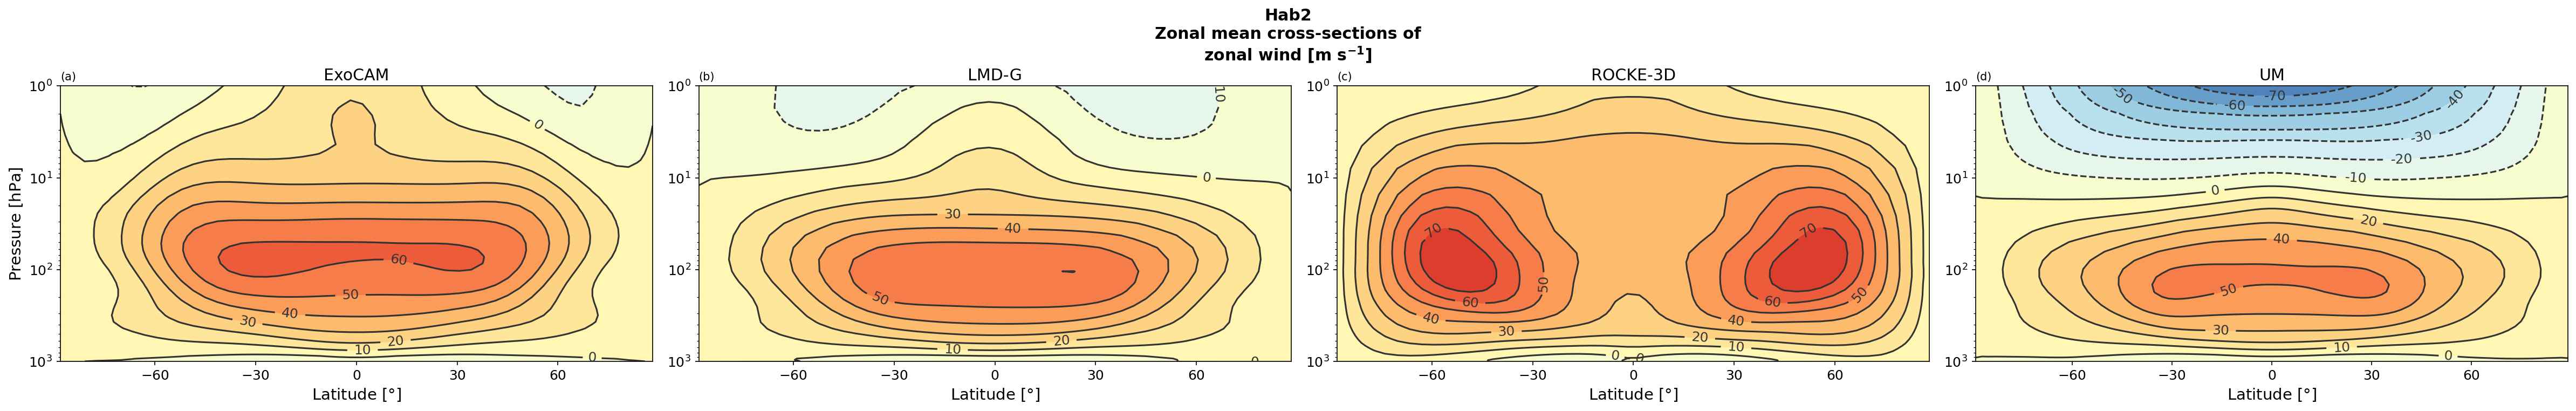

In [9]:
# reduce = lambda a: a.sel(latitude=0, method="nearest")
reduce = zonal_mean
case = THAI_case
ncols = 4
nrows = len(VARIABLES)

fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(ncols * 8, nrows * 4.5), squeeze=False
)
iletters = aplt.subplot_label_generator()
for ax in axs.flat:
    ax.set_title(f"({next(iletters)})", **KW_SBPLT_LABEL)
    ax.set_ylim(1000, 1)
    # ax.set_yticklabels([1000, 100, 10, 1])
    ax.set_yscale("log")
    ax.set_xticks(YLOCS)
    # for ix in YLOCS[1:-1]:
    #     ax.axvline(ix, color="tab:grey", alpha=0.5)
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Pressure [$hPa$]")
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Latitude [$\degree$]")

mappables = []
for (varkey, vardict), axrow in zip(VARIABLES.items(), axs):
    for model_key, ax in zip(MODELS.keys(), axrow):
        ax.set_title(MODELS[model_key]["title"], **KW_MAIN_TTL)
        model_names = names[model_key]
        pres = spatial_mean(datasets[case][model_key][model_names.pres])
        if model_key != "ROCKE3D":
            # Pa to hPa
            pres /= 1e2
        lats = datasets[case][model_key][model_names.y]
        arr = vardict["func"](datasets[case][model_key], model_key)
        arr = reduce(arr)

        cntrf = getattr(ax, vardict["method"])(
            lats,
            pres,
            arr,
            **vardict["kw_plt"],
        )
        cntr = ax.contour(
            lats, pres, arr, colors="#333333", levels=vardict["kw_plt"]["levels"]
        )
        ax.clabel(cntr, fmt="%.0f", colors="#333333")
    mappables.append(cntrf)

fig.tight_layout()

# for cntrf, vardict, axrow in zip(mappables, VARIABLES.values(), axs):
#     cbar = fig.colorbar(cntrf, ax=axrow, pad=0.01, orientation="vertical", aspect=20)
#     cbar.ax.set_ylabel(f"{vardict['title']} [{vardict['tex_units']}]")

ttl = (
    "Zonal mean cross-sections of"
    f"\n{vardict['title'].lower()} [{vardict['tex_units']}]"
)
fig.suptitle(f"{case}\n{ttl}", y=1.125, fontweight="bold")
figsave(
    fig,
    mypaths.plotdir / f"{THAI_case}__py_zm_u_logscale",
)